# Data preparation and analysis (with_outliers)


## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import random
import plotly.express as px
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_validate, train_test_split
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

## Load Data

In [2]:
#load dataframe

#outlier_folder = "witout_outliers"
outlier_folder = "with_outliers"
df_genes_labels_file = f'Data/{outlier_folder}/df_genes_labels_tmm.pkl'
if os.path.exists(df_genes_labels_file):
    df_genes_labels = pd.read_pickle(df_genes_labels_file)
else:
    raise Exception("You need to run the notebook \"PrepareDataExploratoryAnalysis\".")

df_genes_labels[['Classification', 'Patient_group', 'Center',
 'Source', 'Cell_type', 'Group', 'Stage', 'Sex']] = df_genes_labels[['Classification', 'Patient_group', 'Center',
  'Source', 'Cell_type', 'Group', 'Stage', 'Sex']].apply(lambda x: pd.factorize(x)[0])

expression_data = df_genes_labels.iloc[:, :5440]
labels = df_genes_labels.iloc[:, 5440:5441].values.ravel()

## Reduce dimensionality

References:

https://www.researchgate.net/publication/339646247_Gene_Expression_Classification_Based_on_Deep_Learning <br>
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-04527-4 <br>
https://arxiv.org/abs/2301.12222


### Useful functions

In [3]:
# Estimate best hyperparams to SVC, RandomForest and K-NN
# defining parameter range

def estimate_hyper_svc(expression_data_selected, labels, cores):
    param_grid = {
        'tol': [0.1, 0.01, 0.001, 0.0001, 1e-4, 1e-5, 1e-6],
        'dual':[True],
        'multi_class':['ovr', 'crammer_singer'],
        'class_weight': ('balanced', 'None')} 
    grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 1, scoring='roc_auc', n_jobs=cores)
    X_train, X_test, y_train, y_test = train_test_split(expression_data_selected, labels, test_size=0.40, random_state=42, stratify=labels)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        grid.fit(X_train, y_train)
    # print best score
    print(grid.best_score_)
    # print best parameter after tuning
    print(grid.best_params_)
    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)
    return grid

def estimate_hyper_rf(expression_data_selected, labels, cores):
    param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}
    grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv = 3, n_jobs = cores, verbose = 1)
    X_train, X_test, y_train, y_test = train_test_split(expression_data_selected, labels, test_size=0.40, random_state=42, stratify=labels)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        grid.fit(X_train, y_train)
    # print best score
    print(grid.best_score_)
    # print best parameter after tuning
    print(grid.best_params_)
    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)
    return grid

def estimate_hyper_knn(expression_data_selected, labels, cores):
    k_range = list(range(1, 50))
    param_grid = dict(n_neighbors=k_range)
    grid = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = param_grid, cv = 3, n_jobs = cores, verbose = 1, scoring='accuracy')
    X_train, X_test, y_train, y_test = train_test_split(expression_data_selected, labels, test_size=0.40, random_state=42, stratify=labels)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        grid.fit(X_train, y_train)
    # print best score
    print(grid.best_score_)
    # print best parameter after tuning
    print(grid.best_params_)
    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)
    return grid

def print_evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    print('Model Performance with best hyperparameters')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print("Accuracy score %.3f" %metrics.accuracy_score(test_labels, predictions))

def run_model(model, expression_data, labels):
    X_train, X_test, y_train, y_test = train_test_split(expression_data, labels, test_size=0.40, random_state=42, stratify=labels)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        model.fit(X_train, y_train)
    scores = model.score(X_test, y_test)
    y_pred = model.predict(X_test)        
    print_evaluate(model, X_test, y_test)

def evaluate_models(expression_data_selected, labels):
    print('---SVC---')
    grid = estimate_hyper_svc(expression_data_selected, labels, -1)
    # Run model with parameters obtained
    run_model(grid.best_estimator_, expression_data_selected, labels)
    print('---Random Forest---')
    grid = estimate_hyper_rf(expression_data_selected, labels, -1)
    # Run model with parameters obtained
    run_model(grid.best_estimator_, expression_data_selected, labels)
    print('---K-NN---')
    grid = estimate_hyper_knn(expression_data_selected, labels, -1)
    # Run model with parameters obtained
    run_model(grid.best_estimator_, expression_data_selected, labels)

### Embedded methods (Lasso (L1 regression) and decision trees (feature importance based on purity))

In [4]:
# load/save result (10 min)
df_genes_labels_file = f'Data/{outlier_folder}/df_expression_data_lasso_tmm.pkl'
if os.path.exists(df_genes_labels_file):
    df_expression_data_selected_lasso = pd.read_pickle(df_genes_labels_file)    
else:
    k = 50 # number of features (genes) to select
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        lasso = LassoCV(cv=5, n_jobs=-1).fit(expression_data, labels)
    coef = np.abs(lasso.coef_)
    important_genes = coef.argsort()[-k:][::-1]
    df_expression_data_selected_lasso = expression_data.iloc[:, important_genes]
    df_expression_data_selected_lasso.to_pickle(df_genes_labels_file)

In [9]:
# Evaluate features selected in SVC, Random Forest and K-NN models (10 min)
evaluate_models(df_expression_data_selected_lasso, labels)

---SVC---
Fitting 5 folds for each of 28 candidates, totalling 140 fits
0.8802098685628097
{'class_weight': 'balanced', 'dual': True, 'multi_class': 'crammer_singer', 'tol': 1e-06}
LinearSVC(class_weight='balanced', multi_class='crammer_singer', tol=1e-06)
Model Performance with best hyperparameters
Average Error: 0.2019 degrees.
Accuracy score 0.798
---Random Forest---
Fitting 3 folds for each of 288 candidates, totalling 864 fits
0.785106219330226
{'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 200}
RandomForestClassifier(max_depth=100, max_features=3, min_samples_leaf=3,
                       min_samples_split=12, n_estimators=200)
Model Performance with best hyperparameters
Average Error: 0.1966 degrees.
Accuracy score 0.803
---K-NN---
Fitting 3 folds for each of 49 candidates, totalling 147 fits
0.7979848324026643
{'n_neighbors': 7}
KNeighborsClassifier(n_neighbors=7)
Model Performance with best hyperparamet

### Regularization methods (Elastic Net (L1 and L2) regression)

In [10]:
# load/save result (69 min)
df_genes_labels_file =f'Data/{outlier_folder}/df_expression_data_reg_Elastic_net_tmm.pkl'
if os.path.exists(df_genes_labels_file):
    df_expression_data_selected_elastic_net = pd.read_pickle(df_genes_labels_file)    
else:
    k = 50 # number of features (genes) to select
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        elastic_net = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, n_jobs=-1).fit(expression_data, labels)
    coef = np.abs(elastic_net.coef_)
    important_genes = coef.argsort()[-k:][::-1]
    df_expression_data_selected_elastic_net = expression_data.iloc[:, important_genes]
    df_expression_data_selected_elastic_net.to_pickle(df_genes_labels_file)

In [11]:
# Evaluate features selected in SVC, Random Forest and K-NN models (10 min)
evaluate_models(df_expression_data_selected_elastic_net, labels)

---SVC---
Fitting 5 folds for each of 28 candidates, totalling 140 fits
0.880068950657186
{'class_weight': 'balanced', 'dual': True, 'multi_class': 'ovr', 'tol': 0.01}
LinearSVC(class_weight='balanced', tol=0.01)
Model Performance with best hyperparameters
Average Error: 0.2299 degrees.
Accuracy score 0.770
---Random Forest---
Fitting 3 folds for each of 288 candidates, totalling 864 fits
0.7843909117479656
{'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 200}
RandomForestClassifier(max_depth=110, max_features=3, min_samples_leaf=4,
                       min_samples_split=8, n_estimators=200)
Model Performance with best hyperparameters
Average Error: 0.1890 degrees.
Accuracy score 0.811
---K-NN---
Fitting 3 folds for each of 49 candidates, totalling 147 fits
0.7958358330641314
{'n_neighbors': 15}
KNeighborsClassifier(n_neighbors=15)
Model Performance with best hyperparameters
Average Error: 0.1805 degrees.
Accuracy

### Wrapper methods (Recursive Feauture Elimination(RFE) and sequential forward or back selection)

In [12]:
# load/save result (176 min)
df_genes_labels_file =f'Data/{outlier_folder}/df_expression_data_rfe_tmm.pkl'
if os.path.exists(df_genes_labels_file):
     df_expression_data_selected_rfe = pd.read_pickle(df_genes_labels_file)    
else:
     k = 50 # number of features (genes) to select
     selector = RFE(LogisticRegression(n_jobs=-1), n_features_to_select=k, step=1)
     expression_data_selected_rfe = selector.fit_transform(expression_data, labels)
     df_expression_data_selected_rfe = expression_data[selector.get_feature_names_out()]
     df_expression_data_selected_rfe.to_pickle(df_genes_labels_file)

In [13]:
# Evaluate features selected in SVC, Random Forest and K-NN models (10 min)
evaluate_models(df_expression_data_selected_rfe, labels)

---SVC---
Fitting 5 folds for each of 28 candidates, totalling 140 fits
0.9060008618832148
{'class_weight': 'balanced', 'dual': True, 'multi_class': 'ovr', 'tol': 0.0001}
LinearSVC(class_weight='balanced')
Model Performance with best hyperparameters
Average Error: 0.2470 degrees.
Accuracy score 0.753
---Random Forest---
Fitting 3 folds for each of 288 candidates, totalling 864 fits
0.7729352223606689
{'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
RandomForestClassifier(max_depth=90, max_features=3, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=200)
Model Performance with best hyperparameters
Average Error: 0.2137 degrees.
Accuracy score 0.786
---K-NN---
Fitting 3 folds for each of 49 candidates, totalling 147 fits
0.7822465272970603
{'n_neighbors': 36}
KNeighborsClassifier(n_neighbors=36)
Model Performance with best hyperparameters
Average Error: 0.1933 degrees.
Accuracy score 0.

### Filter methods (t-test, chi-square test, Pearson correlation, or mutual information)

In [14]:
# load/save result (35 min)
df_genes_labels_file =f'Data/{outlier_folder}/df_expression_data_filter_methods_tmm.pkl'
if os.path.exists(df_genes_labels_file):
     df_expression_data_selected_filters = pd.read_pickle(df_genes_labels_file)    
else:
     k = 50 # number of features (genes) to select
     selector = SelectKBest(f_classif, k=k)
     expression_data_selected_filters = selector.fit_transform(expression_data, labels)
     df_expression_data_selected_filters = expression_data[selector.get_feature_names_out()]
     df_expression_data_selected_filters.to_pickle(df_genes_labels_file)

In [15]:
# Evaluate features selected in SVC, Random Forest and K-NN models (10 min)
evaluate_models(df_expression_data_selected_filters, labels)

---SVC---
Fitting 5 folds for each of 28 candidates, totalling 140 fits
0.80647848883143
{'class_weight': 'balanced', 'dual': True, 'multi_class': 'crammer_singer', 'tol': 0.0001}
LinearSVC(class_weight='balanced', multi_class='crammer_singer')
Model Performance with best hyperparameters
Average Error: 0.2331 degrees.
Accuracy score 0.767
---Random Forest---
Fitting 3 folds for each of 288 candidates, totalling 864 fits
0.7750703770363191
{'bootstrap': True, 'max_depth': 110, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
RandomForestClassifier(max_depth=110, max_features=2, min_samples_leaf=3,
                       min_samples_split=8)
Model Performance with best hyperparameters
Average Error: 0.2202 degrees.
Accuracy score 0.780
---K-NN---
Fitting 3 folds for each of 49 candidates, totalling 147 fits
0.774353531158183
{'n_neighbors': 21}
KNeighborsClassifier(n_neighbors=21)
Model Performance with best hyperparameters
Average Error: 0.2137 degr

### Compare feture sets and extract commun genes

In [16]:
common_genes_four_selection = np.intersect1d(np.intersect1d(df_expression_data_selected_lasso.columns, df_expression_data_selected_elastic_net.columns),
                            np.intersect1d(df_expression_data_selected_rfe.columns, df_expression_data_selected_filters.columns))
print(common_genes_four_selection)

[]


In [17]:
common_genes_Lasso_EkastinNet = np.intersect1d(df_expression_data_selected_lasso.columns,
                                                df_expression_data_selected_elastic_net.columns)
print(common_genes_Lasso_EkastinNet)
print(f'Number of common elements {len(common_genes_Lasso_EkastinNet)}')

['ENSG00000012223' 'ENSG00000069535' 'ENSG00000070961' 'ENSG00000096060'
 'ENSG00000100079' 'ENSG00000102781' 'ENSG00000103316' 'ENSG00000103423'
 'ENSG00000103495' 'ENSG00000107742' 'ENSG00000108264' 'ENSG00000115457'
 'ENSG00000115738' 'ENSG00000116191' 'ENSG00000118503' 'ENSG00000120656'
 'ENSG00000122965' 'ENSG00000125124' 'ENSG00000130948' 'ENSG00000134574'
 'ENSG00000138795' 'ENSG00000142089' 'ENSG00000142856' 'ENSG00000143546'
 'ENSG00000143669' 'ENSG00000151789' 'ENSG00000154917' 'ENSG00000157193'
 'ENSG00000158578' 'ENSG00000163131' 'ENSG00000164091' 'ENSG00000164116'
 'ENSG00000164674' 'ENSG00000167286' 'ENSG00000169429' 'ENSG00000174365'
 'ENSG00000180817' 'ENSG00000182463' 'ENSG00000184613' 'ENSG00000184634'
 'ENSG00000203875' 'ENSG00000213465' 'ENSG00000228651' 'ENSG00000238683'
 'ENSG00000240225' 'ENSG00000260661' 'ENSG00000269028']
Number of common elements 47


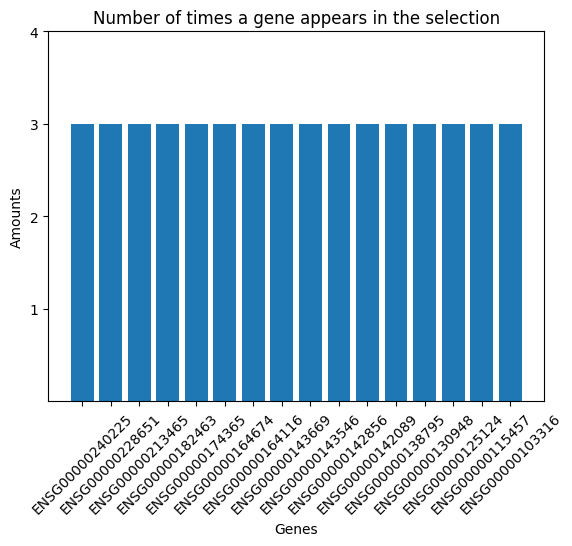

In [18]:
all_genes = np.concatenate((df_expression_data_selected_lasso.columns,
                            df_expression_data_selected_elastic_net.columns,
                            df_expression_data_selected_rfe.columns,
                            df_expression_data_selected_filters.columns))
items, amounts = np.unique(all_genes, return_counts=True)
filtered_items = items[amounts > 2]
filtered_amounts = amounts[amounts > 2]

sorted_indexes = np.argsort(filtered_amounts)[::-1]
sorted_items = filtered_items[sorted_indexes]
sorted_amounts = filtered_amounts[sorted_indexes]
plt.bar(sorted_items, sorted_amounts)
plt.xlabel('Genes')
plt.ylabel('Amounts')
plt.xticks(rotation=45)
plt.yticks(np.arange(1, 5))
plt.title('Number of times a gene appears in the selection')
plt.show()

In [19]:
df_genes_labels_file = f'Data/{outlier_folder}/df_six_main_tmm.pkl'
df_six_principals = expression_data[sorted_items]
df_six_principals.to_pickle(df_genes_labels_file)

In [20]:
evaluate_models(df_six_principals, labels)

---SVC---
Fitting 5 folds for each of 28 candidates, totalling 140 fits
0.8070924369747899
{'class_weight': 'balanced', 'dual': True, 'multi_class': 'ovr', 'tol': 0.0001}
LinearSVC(class_weight='balanced')
Model Performance with best hyperparameters
Average Error: 0.2159 degrees.
Accuracy score 0.784
---Random Forest---
Fitting 3 folds for each of 288 candidates, totalling 864 fits
0.7636239174242774
{'bootstrap': True, 'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
RandomForestClassifier(max_depth=90, max_features=3, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=200)
Model Performance with best hyperparameters
Average Error: 0.2019 degrees.
Accuracy score 0.798
---K-NN---
Fitting 3 folds for each of 49 candidates, totalling 147 fits
0.7593136123802052
{'n_neighbors': 29}
KNeighborsClassifier(n_neighbors=29)
Model Performance with best hyperparameters
Average Error: 0.2084 degrees.
Accuracy score 0.